<h2>Capstone Project - Finding the Indian Restaurants</h2>

<b>1.Introduction & Business Problem:</b>

There is one Indian man who is going to New York City for a two month. He is going there only for two month because he got a invitation to attend the largest annual tech event of "XYZ" company and after that he will be back to India. 
So the problem is this: 
* He want to rent a flat for a two month in the area where he will easily get the Indian Restaurants or Indian Cuisine. 

Solution of this problem:
* I am going to take the data of New York city and with the help of Foursquare API will get that which Borough and its Neighborhood having maximum number of Indian Cuisine/ Indian Restaurants.
* And after we will display it on a map so the Indian person can get in which area/borough he should search a flat for rent.

<b>2. Data Requirements and Data Acquisition:</b>

Data 1: Data source: https://cocl.us/new_york_dataset
Description: This data set contains the required information. And we will use this data set to explore various neighbourhoods of New York city.
Neighbourhood has a total of 5 boroughs and 306 neighbourhoods. In order to segment the
neighbourhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighbourhoods that exist in each borough as well as the latitude and longitude coordinates of each neighbourhood.

Data 2: Indian restaurants in each neighbourhood of New York city.
Data source: Foursquare API
Description: By using this api we will get all the venues in each neighbourhood. We can filter these venues to get only Indian restaurants.

Data 3: GeoSpace data
Data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description: By using this geo space data we will get the New York Borough boundaries that will help us visualize choropleth map.


<b>Analysis</b>

We will import the required libraries for python.
*	pandas and numpy for handling data.
*	request module for using FourSquare API.
*	geopy to get co-ordinates of City of New York.
*	folium to visualize the results on a map


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
!conda install -c conda-forge geocoder --yes
!conda install -c conda-forge geopy --yes
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'PCHJWHCGPSBGNTVVU5KZGTIQNJOQBCLZYZGIFUSZG45JT2OR' # your Foursquare ID
    CLIENT_SECRET = '5LS1QKJD3N3G5TGIXDJOC1LSCPFYB5LD3BLL0PJTSUZQ34Z5' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0G0KFCU55P01WMUAE5ZSE1NRPQQIP5F0J5EY1ZI0IKHQDNYG' # your Foursquare ID
    CLIENT_SECRET = 'QU5PJIGT233ERHLCAVAPFPLYPGJ1KDN1YJYTFJHRBADVWJWM'# your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

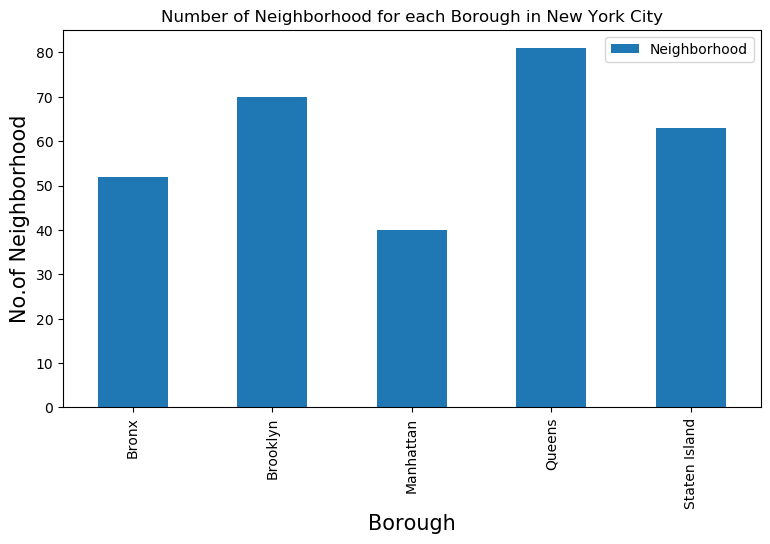

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now we will collect Indian restaurants for each Neighborhood

In [14]:
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:1
( 10 / 306 ) Indian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Restaurants in Baychester, Bronx:0
( 12 / 306 ) Indian Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Restaurants in City Island, Bronx:0
( 14 / 306 ) Indian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Indian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Indian Restaurants in East Tremont, Bronx:

Now that we have got all the indian restaurants in new york city , we will analyze it

In [15]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Norwood,57363fd4498eb703a5b5ea35,Aman Restaurant
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [16]:
indian_rest_ny.shape

(148, 4)

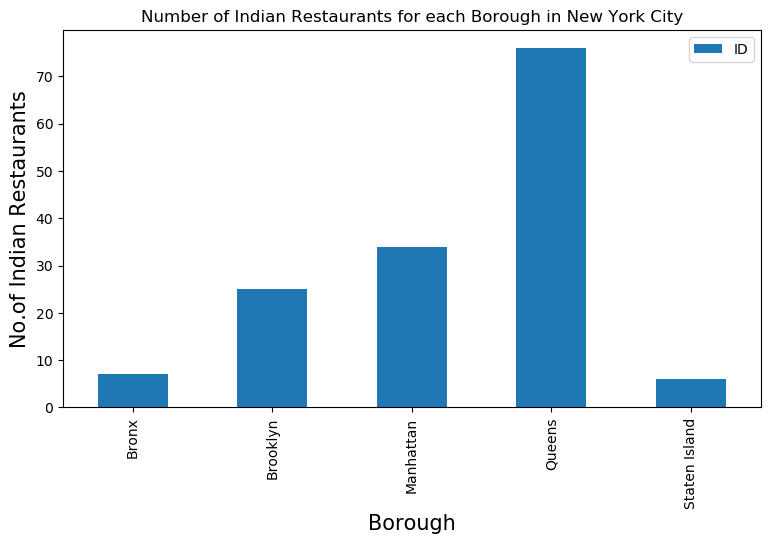

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

**Above**  Here after visualization we can get that "Queens" Borough is having the most number of Indian Restaurants.

**Now** Lets get to know about that how many indian restaurants are there in each Neighborhood.

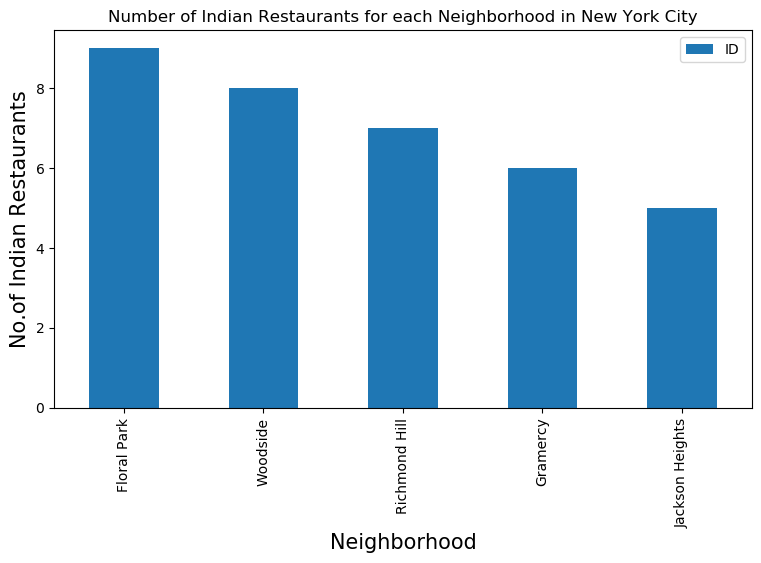

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

**Above**  Here after visualization we knew that "Floral Park" Neighborhood is having the max number of Indian restaurants.

In [26]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
105,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
106,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
107,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
108,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
109,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
110,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
111,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
112,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
113,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


Now we will get the ranking of each resturant for further analysis.

In [28]:
indian_rest_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       148 non-null    object
 1   Neighborhood  148 non-null    object
 2   ID            148 non-null    object
 3   Name          148 non-null    object
dtypes: object(4)
memory usage: 4.8+ KB


**Below**  We will join this dataset to original new york data to get longitude and latitude

In [36]:
ny_neighborhood_stats=pd.merge(indian_rest_ny,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough_x','Neighborhood','Latitude','Longitude']]
ny_neighborhood_stats


,Borough_x,Neighborhood,Latitude,Longitude
0,Bronx,Woodlawn,40.898273,-73.867315
1,Bronx,Norwood,40.877224,-73.879391
2,Bronx,Parkchester,40.837938,-73.856003
3,Bronx,Spuyten Duyvil,40.881395,-73.917190
4,Bronx,Concourse,40.834284,-73.915589
5,Bronx,Unionport,40.829774,-73.850535
6,Brooklyn,Bay Ridge,40.625801,-74.030621
7,Brooklyn,Bay Ridge,40.625801,-74.030621
8,Brooklyn,Brighton Beach,40.576825,-73.965094
9,Brooklyn,Flatbush,40.636326,-73.958401


<h4>Now lets visualize on the map that in which area having the maximum number of Indian Restaurants.</h4>

Now we will show this data on a map

In [37]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [38]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough_x']

In [39]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

<b>Results</b>
1. Here after visualization it is clear that the "Queens" Borough is having the maximum number of Indian Restaurants.
2. And the "Floral Park" is having the maximum number of Indian Restaurants and followed by "Woodside" and "Richmond Hill".

<b>Conclusion</b>

* So Here after doing the analysis and Visualization we knew that "Floral Park" is having the maximum number of India Restaurants which is a Neighborhood of "Queens" Borough.
* So the Indian man who is going to New York city he should search the flat in the "Queens" Borough near the "Floral Park" or inside the area of "Floral Park" or inside of "Woodside" and "Richmond Hill" Neighborhood so he will not facing the issue of Indian Cuisine.
 